In [1]:
import os
import sys

In [2]:
import glob
import uuid

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.cuda.amp import autocast
import torchvision
import torchvision.transforms as T

In [3]:
def viz(w, show=True):
    w = w.detach().cpu()
#     w = w - w.min()
#     w = w / w.max()
    w = (w + 1.0) / 2.0
    
    if len(w.shape) == 3:
        w = w.unsqueeze(0)
    if w.shape[0] > 1:
        w = torchvision.utils.make_grid(w)
    else:
        w = w.squeeze(0)
    w = w.permute(1, 2, 0)
    if show:
        plt.figure(figsize=(10, 10))
        plt.imshow(w)
        plt.axis('off')
        plt.show()
    else:
        return w

# setup

In [4]:
def save_model(model, i):
    sd = model.state_dict()
    torch.save(model.state_dict(), 'resnet18_%s.pth.tar' % i)

def load_model(model, i):
    sd = torch.load('resnet18_%s.pth.tar' % i)
    model.load_state_dict(sd)

In [5]:
from ffcv.fields import IntField, RGBImageField
from ffcv.fields.decoders import IntDecoder, SimpleRGBImageDecoder
from ffcv.loader import Loader, OrderOption
from ffcv.transforms import RandomHorizontalFlip, Cutout, \
    RandomTranslate, Convert, ToDevice, ToTensor, ToTorchImage
from ffcv.transforms.common import Squeeze

CIFAR_MEAN = [125.307, 122.961, 113.8575]
CIFAR_STD = [51.5865, 50.847, 51.255]

## fast FFCV data loaders
device = 'cuda:0' 
label_pipeline = [IntDecoder(), ToTensor(), ToDevice(device), Squeeze()]
image_pipeline = [
    SimpleRGBImageDecoder(),
    ToTensor(),
    ToDevice(device, non_blocking=True),
    ToTorchImage(),
    Convert(torch.float16),
    T.Normalize(CIFAR_MEAN, CIFAR_STD),
]
image_aug_pipeline = [
    SimpleRGBImageDecoder(),
    #
    RandomHorizontalFlip(),
    RandomTranslate(padding=2),
    Cutout(12, tuple(map(int, CIFAR_MEAN))),
    #
    ToTensor(),
    ToDevice(device, non_blocking=True),
    ToTorchImage(),
    Convert(torch.float16),
    T.Normalize(CIFAR_MEAN, CIFAR_STD),
]

# Create loaders
train_aug_loader = Loader(f'/tmp/cifar_train.beton',
                      batch_size=512,
                      num_workers=8,
                      order=OrderOption.RANDOM,
                      drop_last=True,
                      pipelines={'image': image_aug_pipeline,
                                 'label': label_pipeline})
train_loader = Loader(f'/tmp/cifar_train.beton',
                      batch_size=512,
                      num_workers=8,
                      order=OrderOption.RANDOM,
                      drop_last=True,
                      pipelines={'image': image_pipeline,
                                 'label': label_pipeline})
test_loader = Loader(f'/tmp/cifar_test.beton',
                     batch_size=512,
                     num_workers=8,
                     order=OrderOption.SEQUENTIAL,
                     drop_last=False,
                     pipelines={'image': image_pipeline,
                                'label': label_pipeline})
# this loader will be used to compute the permutation
val_loader = train_loader
# val_loader = train_aug_loader

In [6]:
def evaluate(model, set_eval=True):
    if set_eval:
        model.eval()
    else:
        model.train()
    correct = 0
    it = iter(test_loader)
    with torch.no_grad(), autocast():
        for batch in it:
            inputs, labels = batch
            outputs = model(inputs.cuda())
            pred = outputs.argmax(dim=1)
            correct += (labels == pred).sum().item()
    return correct

In [7]:
from torch import nn
import torch.nn.functional as F

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes)

### matching code

In [8]:
# given two networks net0, net1 which each output a feature map of shape NxCxWxH
# this will reshape both outputs to (N*W*H)xC
# and then compute a CxC correlation matrix between the outputs of the two networks
def run_corr_matrix(net0, net1):
    n = len(val_loader)
    mean0 = mean1 = std0 = std1 = None
    with torch.no_grad():
        net0.eval()
        net1.eval()
        for i, (images, target) in enumerate(tqdm(val_loader)):
            out0 = net0(images.float())
            out0 = out0.reshape(out0.shape[0], out0.shape[1], -1).permute(0, 2, 1)
            out0 = out0.reshape(-1, out0.shape[2]).float()
            
            out1 = net1(images.float())
            out1 = out1.reshape(out1.shape[0], out1.shape[1], -1).permute(0, 2, 1)
            out1 = out1.reshape(-1, out1.shape[2]).float()
            
            mean0_b = out0.mean(dim=0)
            mean1_b = out1.mean(dim=0)
            std0_b = out0.std(dim=0)
            std1_b = out1.std(dim=0)
            outer_b = (out0.T @ out1) / out0.shape[0]
            
            if i == 0:
                mean0 = torch.zeros_like(mean0_b)
                mean1 = torch.zeros_like(mean1_b)
                std0 = torch.zeros_like(std0_b)
                std1 = torch.zeros_like(std1_b)
                outer = torch.zeros_like(outer_b)
            mean0 += mean0_b / n
            mean1 += mean1_b / n
            std0 += std0_b / n
            std1 += std1_b / n
            outer += outer_b / n

    cov = outer - torch.outer(mean0, mean1)
    corr = cov / (torch.outer(std0, std1) + 1e-4)
    return corr

In [9]:
def compute_perm_map(corr_mtx):
    # sort the (i, j) channel pairs by correlation
    nchan = corr_mtx.shape[0]
    triples = [(i, j, corr_mtx[i, j].item()) for i in range(nchan) for j in range(nchan)]
    triples = sorted(triples, key=lambda p: -p[2])
    # greedily find a matching
    perm_d = {}
    for i, j, c in triples:
        if not (i in perm_d.keys() or j in perm_d.values()):
            perm_d[i] = j
    perm_map = torch.tensor([perm_d[i] for i in range(nchan)])

    # qual_map will be a permutation of the indices in the order
    # of the quality / degree of correlation between the neurons found in the permutation.
    # this just for visualization purposes.
    qual_l = [corr_mtx[i, perm_map[i]].item() for i in range(nchan)]
    qual_map = torch.tensor(sorted(range(nchan), key=lambda i: -qual_l[i]))

    return perm_map, qual_map

# returns the channel-permutation to make layer1's activations most closely
# match layer0's.
def get_layer_perm(net0, net1, vizz=False):
    corr_mtx = run_corr_matrix(net0, net1)
    perm_map, qual_map = compute_perm_map(corr_mtx)
    if vizz:
        corr_mtx_viz = (corr_mtx[qual_map].T[perm_map[qual_map]]).T
        viz(corr_mtx_viz)
    return perm_map

In [10]:
# modifies the weight matrices of a convolution and batchnorm
# layer given a permutation of the output channels
def permute_output(perm_map, conv, bn):
    pre_weights = [
        conv.weight,
        bn.weight,
        bn.bias,
        bn.running_mean,
        bn.running_var,
    ]
    for w in pre_weights:
        w.data = w[perm_map]

# modifies the weight matrix of a convolution layer for a given
# permutation of the input channels
def permute_input(perm_map, after_convs):
    if not isinstance(after_convs, list):
        after_convs = [after_convs]
    post_weights = [c.weight for c in after_convs]
    for w in post_weights:
        w.data = w[:, perm_map, :, :]

# Find permutation for each layer

In [11]:
model0 = ResNet18().cuda()
model1 = ResNet18().cuda()

load_model(model0, 'net3')
load_model(model1, 'net4')
# load_model(model0, 'net21')
# load_model(model1, 'net22')

evaluate(model0), evaluate(model1)

(9572, 9581)

## layer1

In [12]:
class Subnet(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        self = self.model
        x = self.conv1(x)
        return x
perm_map = get_layer_perm(Subnet(model0), Subnet(model1))
permute_output(perm_map, model1.conv1, model1.bn1)
permute_output(perm_map, model1.layer1[0].conv2, model1.layer1[0].bn2)
permute_output(perm_map, model1.layer1[1].conv2, model1.layer1[1].bn2)
permute_input(perm_map, [model1.layer1[0].conv1, model1.layer1[1].conv1,
                         model1.layer2[0].conv1, model1.layer2[0].shortcut[0]])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 120.62it/s]


In [13]:
class Subnet(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        self = self.model
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1[0].conv1(x)
        return x
perm_map = get_layer_perm(Subnet(model0), Subnet(model1))
permute_output(perm_map, model1.layer1[0].conv1, model1.layer1[0].bn1)
permute_input(perm_map, model1.layer1[0].conv2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 221.79it/s]


In [14]:
class Subnet(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        self = self.model
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1[0](x)
        x = self.layer1[1].conv1(x)
        return x
perm_map = get_layer_perm(Subnet(model0), Subnet(model1))
permute_output(perm_map, model1.layer1[1].conv1, model1.layer1[1].bn1)
permute_input(perm_map, model1.layer1[1].conv2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 109.27it/s]


## layer2

In [15]:
class Subnet(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        self = self.model
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2[0].conv1(x)
        return x
perm_map = get_layer_perm(Subnet(model0), Subnet(model1))
permute_output(perm_map, model1.layer2[0].conv1, model1.layer2[0].bn1)
permute_input(perm_map, model1.layer2[0].conv2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:01<00:00, 71.87it/s]


In [16]:
class Subnet(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        self = self.model
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        block = self.layer2[0]
        x = F.relu(block.bn1(block.conv1(x)))
        x = block.conv2(x)
        return x
perm_map = get_layer_perm(Subnet(model0), Subnet(model1))
permute_output(perm_map, model1.layer2[0].conv2, model1.layer2[0].bn2)
permute_output(perm_map, model1.layer2[1].conv2, model1.layer2[1].bn2)
permute_output(perm_map, model1.layer2[0].shortcut[0], model1.layer2[0].shortcut[1])
permute_input(perm_map, [model1.layer2[1].conv1,
                         model1.layer3[0].conv1, model1.layer3[0].shortcut[0]])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:01<00:00, 65.68it/s]


In [17]:
class Subnet(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        self = self.model
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2[0](x)
        x = self.layer2[1].conv1(x)
        return x
perm_map = get_layer_perm(Subnet(model0), Subnet(model1))
permute_output(perm_map, model1.layer2[1].conv1, model1.layer2[1].bn1)
permute_input(perm_map, model1.layer2[1].conv2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:01<00:00, 57.64it/s]


## layer3

In [18]:
class Subnet(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        self = self.model
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3[0].conv1(x)
        return x
perm_map = get_layer_perm(Subnet(model0), Subnet(model1))
permute_output(perm_map, model1.layer3[0].conv1, model1.layer3[0].bn1)
permute_input(perm_map, model1.layer3[0].conv2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:01<00:00, 54.69it/s]


In [19]:
class Subnet(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        self = self.model
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        block = self.layer3[0]
        x = F.relu(block.bn1(block.conv1(x)))
        x = block.conv2(x)
        return x
perm_map = get_layer_perm(Subnet(model0), Subnet(model1))
permute_output(perm_map, model1.layer3[0].conv2, model1.layer3[0].bn2)
permute_output(perm_map, model1.layer3[1].conv2, model1.layer3[1].bn2)
permute_output(perm_map, model1.layer3[0].shortcut[0], model1.layer3[0].shortcut[1])
permute_input(perm_map, [model1.layer3[1].conv1,
                         model1.layer4[0].conv1, model1.layer4[0].shortcut[0]])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:01<00:00, 51.42it/s]


In [20]:
class Subnet(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        self = self.model
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3[0](x)
        x = self.layer3[1].conv1(x)
        return x
perm_map = get_layer_perm(Subnet(model0), Subnet(model1))
permute_output(perm_map, model1.layer3[1].conv1, model1.layer3[1].bn1)
permute_input(perm_map, model1.layer3[1].conv2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:02<00:00, 47.81it/s]


## layer4

In [21]:
class Subnet(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        self = self.model
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4[0].conv1(x)
        return x
perm_map = get_layer_perm(Subnet(model0), Subnet(model1))
permute_output(perm_map, model1.layer4[0].conv1, model1.layer4[0].bn1)
permute_input(perm_map, model1.layer4[0].conv2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:02<00:00, 44.45it/s]


In [22]:
class Subnet(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        self = self.model
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        block = self.layer4[0]
        x = F.relu(block.bn1(block.conv1(x)))
        x = block.conv2(x)
        return x
perm_map = get_layer_perm(Subnet(model0), Subnet(model1))
permute_output(perm_map, model1.layer4[0].conv2, model1.layer4[0].bn2)
permute_output(perm_map, model1.layer4[1].conv2, model1.layer4[1].bn2)
permute_output(perm_map, model1.layer4[0].shortcut[0], model1.layer4[0].shortcut[1])
permute_input(perm_map, model1.layer4[1].conv1)
model1.linear.weight.data = model1.linear.weight[:, perm_map]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:02<00:00, 42.84it/s]


In [23]:
class Subnet(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        self = self.model
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4[0](x)
        x = self.layer4[1].conv1(x)
        return x
perm_map = get_layer_perm(Subnet(model0), Subnet(model1))
permute_output(perm_map, model1.layer4[1].conv1, model1.layer4[1].bn1)
permute_input(perm_map, model1.layer4[1].conv2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:02<00:00, 40.48it/s]


## done

In [24]:
evaluate(model1)

9582

In [25]:
save_model(model1, 'net4_perm1')

## mix weights

In [104]:
model_a = ResNet18().cuda(0) # W_\alpha
def mix_weights(alpha, key0, key1, reset_bn=False):
    sd0 = torch.load('resnet18_%s.pth.tar' % key0)
    sd1 = torch.load('resnet18_%s.pth.tar' % key1)
    sd_alpha = {k: (1 - alpha) * sd0[k].cuda() + alpha * sd1[k].cuda()
                for k in sd0.keys()}
    model_a.load_state_dict(sd_alpha)

# use the train loader with data augmentation as this gives better results
def reset_bn_stats(model, epochs=1):
    model.train()
    for _ in range(epochs):
#         with torch.no_grad(), autocast():
#             for images, _ in train_aug_loader:
#                 output = model(images)
        with torch.no_grad():
            for images, _ in train_loader:
                output = model(images.float())

In [105]:
cc = []
xx = np.arange(0, 1.0001, 0.05)
for alpha in tqdm(xx):
    
    mix_weights(alpha, key0='net3', key1='net4_perm1')
    reset_bn_stats(model_a, epochs=1)
    
    c = evaluate(model_a, set_eval=True)
    cc.append(c)
cc = np.array(cc)/100

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:33<00:00,  1.58s/it]


In [28]:
cc1 = cc

In [45]:
cc2 = cc

In [47]:
cc3 = cc

In [59]:
cc4 = cc

In [106]:
cc12 = cc

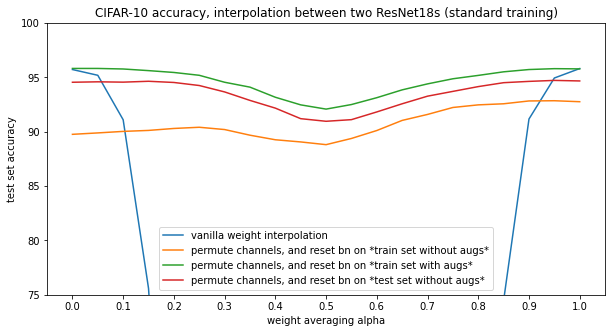

In [111]:
plt.figure(figsize=(10, 5))
plt.title('CIFAR-10 accuracy, interpolation between two ResNet18s (standard training)')

plt.plot(xx, cc1, label='vanilla weight interpolation')
# plt.plot(xx, cc2, label='reset batchnorm statistics without augs')
plt.plot(xx, cc3, label='permute channels, and reset bn on *train set without augs*')
# plt.plot(xx, cc4, label='reset batchnorm statistics with augs')
plt.plot(xx, cc5, label='permute channels, and reset bn on *train set with augs*')
# plt.plot(xx, cc6, label='permute channels, bn not reset')
plt.plot(xx, cc7, label='permute channels, and reset bn on *test set without augs*')

# plt.plot(xx, cc12)

plt.xticks(xx[::2], ['%.1f' % x for x in xx[::2]])
plt.ylim([75, 100])
plt.xlabel('weight averaging alpha')
plt.ylabel('test set accuracy')
plt.legend()
plt.show()